# House Prices: Advanced Regression Techniques
Competition Description


Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

Practice Skills
Creative feature engineering 
Advanced regression techniques like random forest and gradient boosting
Acknowledgments
The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset.

_Source: [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)_

## Table of Contents <a name='table'></a>
- [Load Data](#Load-Data)
- [Find 'Na' Values](#na)
  - [Explore 'Na' Values](#cleanNa)
  - [Fill 'Na' Values](#fillNa)
- [Explore Target Variable (SalePrice)](#target)
- [Explore Continuous Values](#continuous)

***

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.impute import SimpleImputer

## Load Data <a name='Load-Data'></a>
[Table of Cotents](#table)

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
X_train_data = train_data.copy()
X_test_data = test_data.copy()

In [5]:
print(X_train_data.shape)
print(X_test_data.shape)

(1460, 81)
(1459, 80)


In [6]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
def get_feature_list(X_train_data=X_train_data):
    cont_features = X_train_data.select_dtypes(include=np.number).columns.tolist()
    cat_features = X_train_data.select_dtypes(include='object').columns.to_list()
    return (cont_features, cat_features)

In [8]:
cont_features, cat_features = get_feature_list()

## Find and Analyse 'NA' Values <a name ='findNa'></a>
[Table of Contents](#table)

In [9]:
def find_na(df):
    na_find = df.isna().any()
    na_values = df.loc[:,na_find]
    na_col = na_values.columns.tolist()
    heatmap = sns.heatmap(X_train_data.isna(),cmap='binary', cbar=False, yticklabels='none')
    return heatmap

<AxesSubplot:>

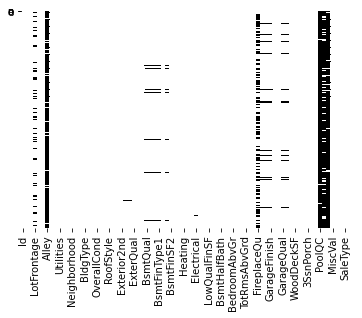

In [10]:
find_na(X_train_data)

<AxesSubplot:>

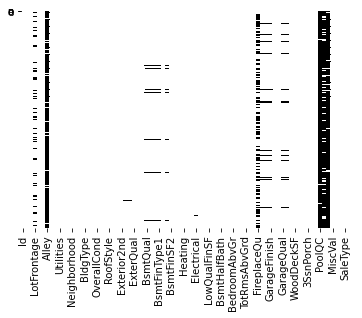

In [11]:
find_na(X_test_data)

In [12]:
na_sum = X_train_data.isna().sum().sort_values(ascending=False)
print(na_sum.loc[na_sum > 0])
print(f'Columns with NaN values: {na_sum.loc[na_sum > 0].count()}')

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64
Columns with NaN values: 19


### Clean 'Na' Values <a name='cleanNa'></a>
[Table of Contents](#table)

Comparing our missing values to our data dictionary many of these 'na' values are a descriptive feature of a dwelling that does not have said feature. 'PoolQC' houses without a pool don't have a 'Pool Quality' rating.

We will fill these 'na' values with 'dna' for does not apply since this is a feature in it of itself.

Column Name| 'Na' Description
-----------|---------------
MiscFeature | None
PoolQC | No Pool
Alley | No alley access
BsmtFinType1 | No Basement
Fence | No Fence
Fireplace | No Fireplace
FireplaceQu | No Fireplace
GarageQual | No Garage
GarageFinish | No Garage
GarageCond | No Garage
GarageType | No Garage    
BsmtExposure | No Basement
BsmtCond | No Basement
BsmtQual | No Basement
BsmtFinType2 | No Basement
BsmtFullBath | None
BsmtHalfBath | None
GarageArea | No Garage

LotFrontage is a measurement.  We will fill this with '0'.
All other NA

In [13]:
dna = ['PoolQC','Alley','BsmtFinType1','Fence','Fireplaces',\
       'FireplaceQu','GarageQual','GarageFinish','GarageCond',\
       'GarageType','BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2',\
       'BsmtFullBath','BsmtHalfBath','GarageArea','MiscFeature']
zero_measure = ['LotFrontage','MasVnrArea','TotalBsmtSF','BsmtFinSF1','BsmtFinSF2']

In [14]:
def impute(df, feature1, feature2):
    
    dna_imputer = SimpleImputer(fill_value='dna',strategy='constant', add_indicator=False)
    dna_out = dna_imputer.fit_transform(df[feature1])
    df.loc[:,feature1] = dna_out
    
    zero_imputer = SimpleImputer(fill_value=0,strategy='constant')
    zero_out = zero_imputer.fit_transform(df[feature2])
    df.loc[:,feature2] = zero_out
    
    print(df.isna().sum().sort_values(ascending=False))

In [15]:
impute(X_train_data, dna, zero_measure)

GarageYrBlt     81
MasVnrType       8
Electrical       1
SalePrice        0
ExterCond        0
                ..
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
Id               0
Length: 81, dtype: int64


Minimal 'Na' values after imputation.  Dropping remaining rows with 'Na' values.

In [16]:
X_train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,dna,Reg,Lvl,AllPub,...,0,dna,dna,dna,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,dna,Reg,Lvl,AllPub,...,0,dna,dna,dna,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,dna,IR1,Lvl,AllPub,...,0,dna,dna,dna,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,dna,IR1,Lvl,AllPub,...,0,dna,dna,dna,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,dna,IR1,Lvl,AllPub,...,0,dna,dna,dna,0,12,2008,WD,Normal,250000


In [17]:
garage_mode = X_train_data['GarageYrBlt'].mode()[0]
X_train_data['GarageYrBlt'].fillna(garage_mode, inplace=True)
X_train_data.dropna(inplace=True)
X_train_data.dropna(inplace=True)

In [18]:
(X_train_data.isna().any or X_test.isna().any) == True

False

---

## Target Variable (SalePrice) <a name='target'></a>
[Table of Contents](#table)

In [19]:
y_train = X_train_data['SalePrice']

Original Skew: 1.8831110462405252
Transformed Skew: 0.1219499636780384


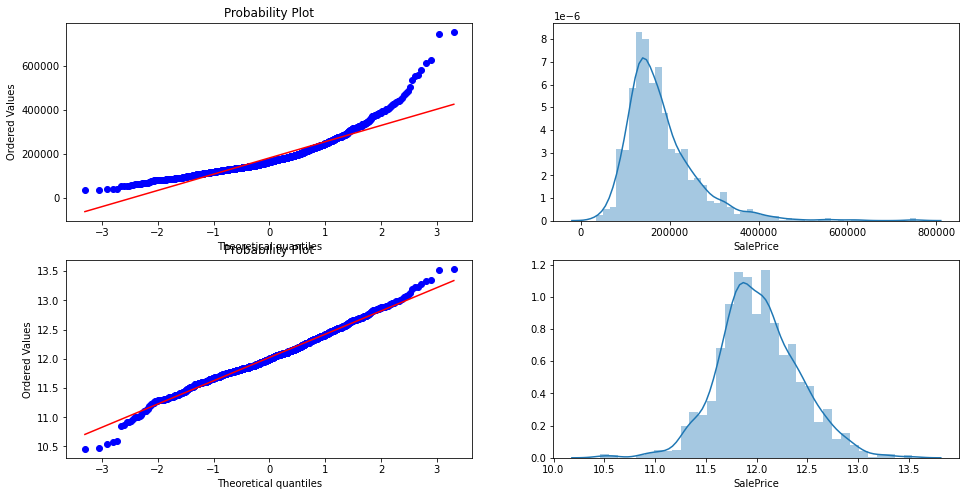

In [20]:
plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
stats.probplot(y_train, dist='norm', fit=True, plot=plt.gca())
plt.subplot(2,2,2)
sns.distplot(y_train)

y_log1p = np.log1p(y_train)
plt.subplot(2,2,3)

stats.probplot(y_log1p, dist='norm', fit=True, plot=plt.gca())
plt.subplot(2,2,4)
sns.distplot(y_log1p)
print(f'Original Skew: {y_train.skew()}')
print(f'Transformed Skew: {y_log1p.skew()}')

---

## Continuous Features <a name='continuous'></a>
[Table of Contents](#table)

In [21]:
corr = X_train_data.corr(method='pearson')

<AxesSubplot:>

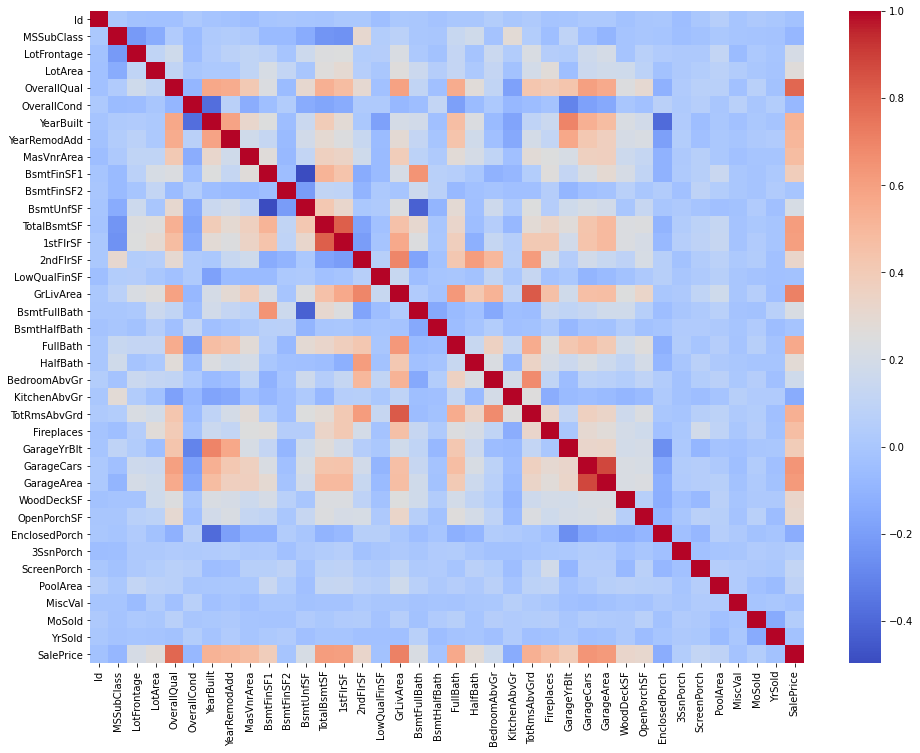

In [22]:
plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap='coolwarm')

In [23]:
corr_values = X_train_data.loc[:,cont_features].corrwith(X_train_data.SalePrice) \
.sort_values(ascending=False)

<AxesSubplot:>

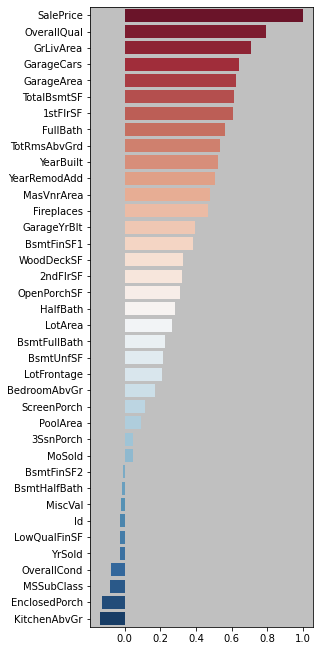

In [24]:
plt.figure(figsize=(4, len(cont_features) * .30))
plt.gca(facecolor='silver')
sns.barplot(x=corr_values,y=corr_values.index, orient='h', palette='RdBu')

In [25]:
ordinal_features = []

def sort(column, sort):
    
    if sort == 'ordinal':
        ordinal_features.append(column)
        print(f'{column} Has been added to the ordinal feature list.')

    elif sort == 'one_hot':
        one_hot_features.append(column)
        print(f'{column} Has been added to the one_hot feature list.')
         
    else:
        return 'Unkown sort value'
    
    return

In [64]:
def outlier_finder(column, k=1.5, df=X_train_data):
    q1, q3 = percentile(df[column], 25), percentile(df[column], 75)
    IQR = q3 - q1
    outliers = (df[(df[column] > q3 + k * IQR)]).index
   
    return len(outliers)

In [65]:
def scribe_stats(column, df=X_train_data):
    
    fig = plt.figure(figsize=(16,4), tight_layout=True)
    
    fig.subplots(1,3)
    
    fig.suptitle(f'Feature Label: {str(column)}', size=20)
    
    plt.subplot(1,3,1)
    sns.distplot(df[column])
    
    plt.subplot(1,3,2)
    sns.boxplot(data=df[column])

    plt.subplot(1,3,3)
    sns.scatterplot(x=df[column],y=df.SalePrice)
    
    plt.show()
    
    outlier_count = outlier_finder(column)
    
    print(f'Skew: {df[column].skew()},\nKurtosis: {df[column].kurtosis()},\n\n\
Outlier Count: {outlier_count}\n\n{df[column].describe()}')
    return

AttributeError: 'DataFrame' object has no attribute 'SalePrice'

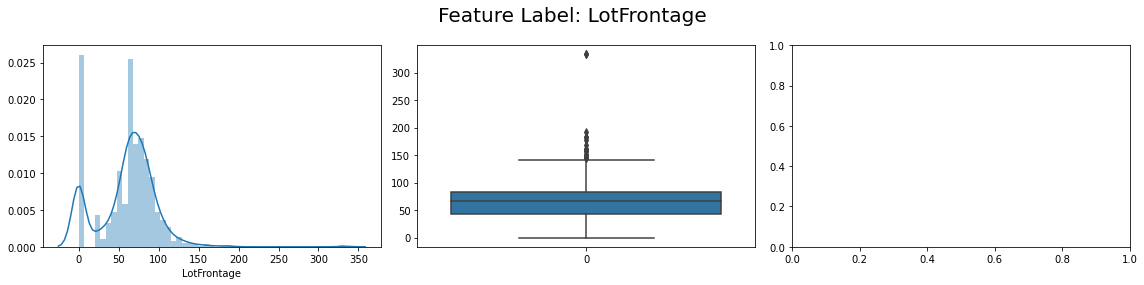

In [66]:
for _ in cont_features:
    scribe_stats(_)

## Observations of continuous variables ##
- [x] The **Id** and **SalePrice** feature columns need to be dropped.
- [x] There are features that has a continuous data type that is actually categorical in nature. I will change this for the following features.
 - *__'YrSold', 'MoSold', 'MSSubClass', 'OverallCond'__*.
- [x] There are features with ordinal values.  I will create a dictionary with their name and order values for later encoding.
  - *__'OverallQual', 'OverallCond', 'MoSold', 'YrSold'__*.
- [ ] There are quite a few outliers.  Since the data isn't gaussian in nature, I will use the IQR method with a factor value of k=3 to identify extreme or "far outs".
- [x] There are features that have a really high skew.  I atempt a box-cox transform on all of the continuous features to see if we can get a more gaussian distribution.

In [59]:
def column_clean(df):
    
    if ('Id' in df.columns):
        df.drop(columns='Id', axis=1, inplace=True)
        
    if ('SalePrice' in df.columns):
        y_train['SalePrice'] = df['SalePrice']
        df.drop(columns='SalePrice', axis=1, inplace=True)
    
#     cat_features.extend(one_hot_features)
# #     cat_features.extend(category_features)
 
#     final_cont = list(set(cont_features) - set(ordinal_features) - set(one_hot_features))
#     final_cat = list(set(cat_features) - set(ordinal_features))
    
    return df, y_train

In [60]:
X_train_data, y_train = column_clean(X_train_data)

In [29]:
one_hot_features = ['YrSold', 'MoSold', 'MSSubClass', 'OverallQual', \
                    'OverallCond', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']  

for c in one_hot_features:
    X_train_data[c] = X_train_data[c].astype('object')

In [30]:
cont_features, _ = get_feature_list()

In [31]:
skew_values = X_train_data.loc[:,cont_features].apply(lambda x: x.skew()) \
.sort_values(ascending=False)
skew_values

MiscVal          24.401513
PoolArea         14.782069
LotArea          12.235742
3SsnPorch        10.271742
LowQualFinSF      8.982567
KitchenAbvGr      4.512817
BsmtFinSF2        4.240230
ScreenPorch       4.107411
BsmtHalfBath      4.088583
EnclosedPorch     3.094001
MasVnrArea        2.668016
OpenPorchSF       2.384908
SalePrice         1.883111
BsmtFinSF1        1.702582
WoodDeckSF        1.541872
TotalBsmtSF       1.535566
GrLivArea         1.373512
1stFlrSF          1.373142
BsmtUnfSF         0.919977
2ndFlrSF          0.815766
HalfBath          0.685128
TotRmsAbvGrd      0.680863
Fireplaces        0.647744
BsmtFullBath      0.604189
LotFrontage       0.273099
BedroomAbvGr      0.217847
GarageArea        0.182585
FullBath          0.037756
Id                0.003576
GarageCars       -0.337419
dtype: float64

In [32]:
high_skew = X_train_data.loc[:,cont_features].skew() > .5

In [33]:
from scipy.special import boxcox1p

for s in high_skew.index:
    X_train_data[s] = boxcox1p(X_train_data[s], stats.boxcox_normmax(X_train_data[s]+1))

C:\Users\Brian\miniconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Brian\miniconda3\lib\site-packages\scipy\stats\stats.py:3875: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [34]:
for o in cont_features:
    print(f'{o}: {outlier_finder(o)}')

Id: 0
LotFrontage: 16
LotArea: 37
MasVnrArea: 2
BsmtFinSF1: 1
BsmtFinSF2: 167
BsmtUnfSF: 1
TotalBsmtSF: 16
1stFlrSF: 4
2ndFlrSF: 4
LowQualFinSF: 26
GrLivArea: 6
BsmtFullBath: 1
BsmtHalfBath: 82
FullBath: 0
HalfBath: 0
BedroomAbvGr: 29
KitchenAbvGr: 66
TotRmsAbvGrd: 12
Fireplaces: 5
GarageCars: 5
GarageArea: 20
WoodDeckSF: 5
OpenPorchSF: 3
EnclosedPorch: 207
3SsnPorch: 24
ScreenPorch: 116
PoolArea: 7
MiscVal: 52
SalePrice: 12


In [57]:
# def outlier_removal(column, df=X_train_data):
for i in cont_features:
# X_train_data = train_data.copy()
    q90 = X_train_data[i].quantile(.9)
    outliers = (X_train_data[(X_train_data[i] > q90)]).any(1)
    print(i, q90, len(outliers))

LotFrontage 96.38090193385139 140
LotArea 9.174126494453029 145
MasVnrArea 24.89429157925188 145
BsmtFinSF1 154.13182531490418 145
BsmtFinSF2 7.602014271892231 145
BsmtUnfSF 107.64576042152738 144
TotalBsmtSF 414.4175128056001 144
1stFlrSF 5.621076765793358 143
2ndFlrSF 1410.4362196241184 145
LowQualFinSF 0.0 26
GrLivArea 7.9170282927449644 145
BsmtFullBath 0.9921642330228064 16
BsmtHalfBath 0.0 82
FullBath 1.9885740760061197 32
HalfBath 1.0694328076341173 12
BedroomAbvGr 3.4521900072813176 29
KitchenAbvGr 0.7174052539531056 66
TotRmsAbvGrd 2.6770108178603156 77
Fireplaces 0.9198155933310497 118
GarageCars 3.80108817878939 5
GarageArea 784.4960365841249 145
WoodDeckSF 57.06192524535142 144
OpenPorchSF 17.730733183206848 142
EnclosedPorch 12.91556063877658 137
3SsnPorch 0.0 24
ScreenPorch 0.0 116
PoolArea 0.0 7
MiscVal 0.0 52


In [58]:
outliers

5       True
7       True
16      True
17      True
51      True
84      True
95      True
98      True
99      True
106     True
214     True
249     True
250     True
335     True
338     True
346     True
392     True
439     True
499     True
502     True
510     True
539     True
589     True
611     True
626     True
634     True
705     True
725     True
733     True
760     True
766     True
767     True
786     True
794     True
800     True
812     True
813     True
867     True
878     True
890     True
912     True
953     True
1061    True
1076    True
1083    True
1171    True
1210    True
1230    True
1252    True
1328    True
1386    True
1457    True
dtype: bool

0.32365910827378025


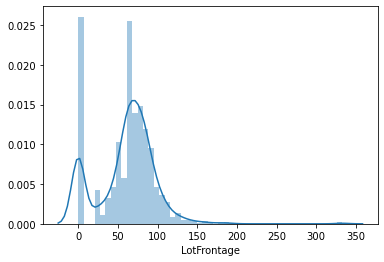

In [36]:
sns.distplot(X_train_data.LotFrontage)
print(X_train_data.LotFrontage.skew())

In [37]:
for o in cont_features:
    print(f'{o}: {outlier_finder(o)}')

Id: 0
LotFrontage: 16
LotArea: 37
MasVnrArea: 2
BsmtFinSF1: 1
BsmtFinSF2: 167
BsmtUnfSF: 1
TotalBsmtSF: 16
1stFlrSF: 4
2ndFlrSF: 4
LowQualFinSF: 26
GrLivArea: 6
BsmtFullBath: 1
BsmtHalfBath: 82
FullBath: 0
HalfBath: 0
BedroomAbvGr: 29
KitchenAbvGr: 66
TotRmsAbvGrd: 12
Fireplaces: 5
GarageCars: 5
GarageArea: 20
WoodDeckSF: 5
OpenPorchSF: 3
EnclosedPorch: 207
3SsnPorch: 24
ScreenPorch: 116
PoolArea: 7
MiscVal: 52
SalePrice: 12


## Catigorical Features <a name='catigorical'></a>
[Table of Contents](#table)

---

In [39]:
cont_f, cat_f = column_clean(X_train_data)

In [40]:
 ordinal_dict = {'OverallQual':[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
                 'OverallCond':[1, 2, 3, 4, 5, 6, 7, 8, 9],
                 'MoSold':[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
                 'YrSold':[2006, 2007, 2008, 2009, 2010],
                 'BsmtQual':['dna', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                 'BsmtCond':['dna', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                 'BsmtFinType1':['dna','Unf','LwQ','Rec','BLQ', 'ALQ', 'GLQ'],
                 'BsmtFinType2':['dna','Unf','LwQ','Rec','BLQ', 'ALQ', 'GLQ'],
                 'HeatingQC':['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                 'KitchenQual':['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                 'Functional':['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
                 'FireplaceQu':['dna', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                 'GarageQual':['dna', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                 'GarageCond':['dna', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                 'PoolQC':['dna','Fa', 'Gd','Ex'],
                 'Fence':['dna', 'MnWw', 'GdWo','MnPrv', 'GdPrv']}


In [41]:
ordinal_list = [value for key,value in ordinal_dict.items()]

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor, BayesianRidge, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score

### Pipeline <a name='Pipeline'></a>
[Table of Contents](#table)

In [43]:
continuous_transform = Pipeline([
    ('scaler', StandardScaler()),
])

In [44]:
categorical_transform = Pipeline([
    ('one_hot', OneHotEncoder(handle_unknown='ignore')),
])

In [45]:
ordinal_transform = Pipeline([
    ('ordinal', OrdinalEncoder()),
])

In [46]:
preprocessor = ColumnTransformer([
    ('cont', StandardScaler(), cont_f),
    ('ordinal', OrdinalEncoder(categories=ordinal_list),ordinal_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_f),
])

In [47]:
linear_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Linear', LinearRegression()),
])

In [48]:
ridge_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Ridge', Ridge(random_state=24)),
])

In [49]:
huber_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Huber', HuberRegressor(max_iter=2000)),
])

In [50]:
lasso_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Lasso', Lasso(random_state=24, fit_intercept=True)),
])

In [51]:
elastic_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('ElasticNet', ElasticNet(random_state=24))
])

In [52]:
svm_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('SVM', LinearSVR(epsilon=1.5))
])

In [53]:
tree_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Tree', RandomForestRegressor(n_estimators=500, max_leaf_nodes=16,n_jobs=-1))
])

In [54]:
pipe_list = [linear_pipe, ridge_pipe, huber_pipe, lasso_pipe, elastic_pipe, svm_pipe, tree_pipe]

In [55]:
def display_scores():
    
    rmse_dict = dict(Model=[],Mean=[],STD=[],Scores=[])

    for pipe in pipe_list:
        scores = cross_val_score(pipe, X_train_data, log1p, scoring='neg_mean_squared_error', cv=5)
        rmse_pipe = np.sqrt(-scores)
        
        rmse_dict['Model'].append(pipe.steps[1][0])
        rmse_dict['Mean'].append(rmse_pipe.mean())
        rmse_dict['STD'].append(rmse_pipe.std())
        rmse_dict['Scores'].append(rmse_pipe)
        
    return pd.DataFrame(rmse_dict)

In [56]:
display_scores()

NameError: name 'log1p' is not defined

In [ ]:
vote_pipe = VotingRegressor([
    ('linear', linear_pipe), ('tree', tree_pipe), ('svc', svm_pipe)],
    n_jobs=-1)

In [ ]:
vote = Pipeline([
    ('preprocessor', preprocessor),
    ('vote',vote_pipe)
])

In [ ]:
scores = cross_val_score(vote_pipe, X_train_data, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_pipe = np.sqrt(-scores)
print(f'{pipe.steps[1][0]}')
print(f'{rmse_pipe.mean()}')
print(f'{rmse_pipe.std()}')
print(f'{rmse_pipe}')

In [ ]:
ada_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('AdaBoost', DecisionTreeRegressor(random_state=24)),
])

In [ ]:
scores = cross_val_score(ada_pipe, X_train_data, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_pipe = np.sqrt(-scores)
print(f'{rmse_pipe.mean()}')
print(f'{rmse_pipe.std()}')
print(f'{rmse_pipe}')